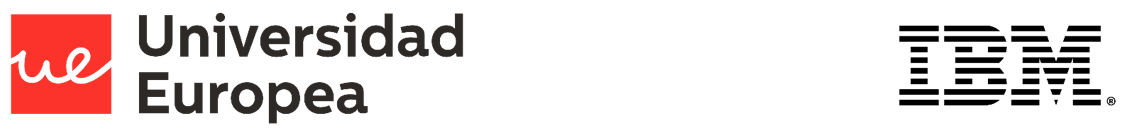
# <font color=#444444> Proyecto: Actividad I - Exploracion de datos </font>
### <font color=#999999> Postgrado Online IA y Data Science 2020-2021 </font>  
**PROFESORAS**: 

**Maria BORBONES GARCIA**                **Maria Cruz GAYA LOPEZ**


**ALUMNOS:**

**Alejandro CASTEL BAIXAULI**           **Vicente José LÁZARO JOARES**

**Miguel COLLADA RODRÍGUEZ**            **Paula Tilly WEISS**

**Manuel FERNÁNDEZ ALBA**


# DATOS

• empleado_id : ID único por candidato

• ciudad: código de la ciudad

• indice_desarrollo_ciudad : índice de desarrollo de la ciudad en escala

• genero: Género del candidato

• experiencia_relevante: Experiencia relevante del candidato

• universidad_matriculado: Tipo de curso universitario en el que se encuentra matriculado

• nivel_educacion: Nivel educativo del candidato

• educacion : Educación

• experiencia: Experiencia en años del candidato

• tamaño_compañia: Número de empleados en el empleador actual

• tipo_compañia : Tipo de actual empleador

• ultimo_nuevo_trabajo: Diferencia en años entre el trabajo actual y el anterior

• horas_formacion: horas de formación completadas

• target: 0 – No busca cambio de trabajo, 1 – Busca un cambio de trabajo


# 1. Carga de los datos


In [50]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [51]:
df_dc = pd.read_csv('ds_job.csv')

Primer vistazo a los datos.

In [52]:
df_dc.head()

,empleado_id,ciudad,indice_desarrollo_ciudad,genero,experiencia_relevante,universidad_matriculado,nivel_educacion,educacion,experiencia,tamano_compania,tipo_compania,ultimo_nuevo_trabajo,horas_formacion,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


Vemos que cada registro tiene un id distinto. Comprobado como primera verificacion en la integridad de los datos.

In [53]:
# lista de variables
l_vars = df_dc.columns.to_list()
l_vars

['empleado_id',
 'ciudad',
 'indice_desarrollo_ciudad',
 'genero',
 'experiencia_relevante',
 'universidad_matriculado',
 'nivel_educacion',
 'educacion',
 'experiencia',
 'tamano_compania',
 'tipo_compania',
 'ultimo_nuevo_trabajo',
 'horas_formacion',
 'target']

In [54]:
# lista columnas categoricas
cats = df_dc.drop(['empleado_id','indice_desarrollo_ciudad','horas_formacion' , 'target'], axis=1).columns.to_list()
cats

['ciudad',
 'genero',
 'experiencia_relevante',
 'universidad_matriculado',
 'nivel_educacion',
 'educacion',
 'experiencia',
 'tamano_compania',
 'tipo_compania',
 'ultimo_nuevo_trabajo']

## Separo en TRAIN y TEST

In [55]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, train_size=0.80, random_state=24)
for train_index, test_index in split.split(df_dc, df_dc['target']):
    df_dc_train = df_dc.loc[train_index].copy()
    df_dc_test = df_dc.loc[test_index].copy()
    
X_train = df_dc_train.drop(columns=['target'])
y_train = df_dc_train['target']
X_test = df_dc_test.drop(columns=['target'])
y_test = df_dc_test['target']


### Funciones auxiliares

Funcion para dibujar los diagramas de quesos.

In [56]:
def pie_col(df,columna):
    val = []
    names = ['NaN']
    val.append(df[columna].isnull().sum())

    for i in df[columna].unique().tolist():
        if not(pd.isnull(i)):
            val.append((df[columna] == i ).sum())
            names = names + [i] 

    pd.DataFrame(val,columns=[columna], index=names).plot.pie(y=columna)



Funcion de ayuda a la imputacion de claves a las que podría resultar bueno no hacer one-hot-encoding.

In [57]:
def trans_clave_valor(df,col,clave,valor):
    df_temp = df[col].copy()
    for i in range(len(clave)):
        df_temp.loc[(df[col]==clave[i])] = valor[i]
        
    return df_temp


## Funciones para Pipeline

In [58]:
from sklearn.base import TransformerMixin

### aux functions

class SelectColumns(TransformerMixin):
    def __init__(self, columns: list) -> pd.DataFrame:
        if not isinstance(columns, list):
            raise ValueError('Specify the columns into a list')
        self.columns = columns
    def fit(self, X, y=None): # we do not need to specify the target in the transformer. We leave it as optional arg for consistency
        return self
    def transform(self, X):
        return X[self.columns]
    
class DropColumns(TransformerMixin):
    def __init__(self, columns: list) -> pd.DataFrame:
        if not isinstance(columns, list):
            raise ValueError('Specify the columns into a list')
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(self.columns, axis=1)
    
    

# Pipelines

In [59]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

### Indice de desarrollo de la ciudad

In [60]:
class tIndDes(TransformerMixin): 
    
    # 'eq' para dejarlo igual
    # 'log' para el log de la variable   
    
    def __init__(self, tipo='eq') -> pd.DataFrame:
        self.tipo = tipo
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if self.tipo == 'eq': 
            X['tIndDes'] = X['indice_desarrollo_ciudad'] 
            return X
        elif self.tipo == 'log':
            X['tIndDes'] = np.log(X[['indice_desarrollo_ciudad']])  
            return X
        else :
            print('ERROR definition tIndDes.tipo')
            
    def set_params(self, **parameters):    # Necesario por error en GridSearch
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self      

### Genero

In [61]:
class tGen(TransformerMixin): 
    
    # 'des' funcion desaparecido de Paula
    # '0.5' 0.5 para Other y para NaN 1 Fem, 0 Male
    
    def __init__(self, tipo='des') -> pd.DataFrame:
        self.tipo = tipo
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if self.tipo == 'des':    # Funcion desaparecido --> hot encoding para esto, no?
            X['tGen'] = X['genero'].replace(np.nan, "desconocido", regex=True)
            return X
        elif self.tipo == '0.5':    # Funcion desaparecido
            clave = ['Male', 'Female', 'Other']
            valor = [0, 1, 0.5]
            X['tGen'] = trans_clave_valor(X,'genero', clave, valor).replace(np.nan, 0.5, regex=True)
            return X
        elif self.tipo == '0.3':    # Funcion desaparecido
            clave = ['Male', 'Female', 'Other']
            valor = [0, 1, 0.3]
            X['tGen'] = trans_clave_valor(X,'genero', clave, valor).replace(np.nan, 0.3, regex=True)         
            return X

        else :
            print('ERROR definition tGen.tipo')
    def set_params(self, **parameters):    # Necesario por error en GridSearch
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self   

### Experiencia relevante

In [62]:
class tExpRel(TransformerMixin): 
    def __init__(self, tipo='des') -> pd.DataFrame:
        self.tipo = tipo
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if self.tipo == 'des':    # Funcion desaparecido
            clave = ['Has relevent experience', 'No relevent experience']
            valor = [1, 0]
            X['tExpRel'] = trans_clave_valor(X,'experiencia_relevante', clave, valor) 
            return X
        else :
            print('ERROR definition tExpRel.tipo')
    def set_params(self, **parameters):    # Necesario por error en GridSearch
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self   

### Universidad matriculado

In [63]:
class tUniversidad(TransformerMixin): 
    def __init__(self, tipo='c_v') -> pd.DataFrame:
        self.tipo = tipo
        self.imp = SimpleImputer(missing_values=np.nan, strategy='median' )
        
    def fit(self, X, y=None):
        if self.tipo == 'c_v_NaN_median':  
            clave = ['no_enrollment', 'Full time course', 'Part time course']
            valor = [0, 2, 1]    
            self.imp.fit(trans_clave_valor(X,'universidad_matriculado', clave, valor).values.reshape(-1,1))
        if self.tipo == 'c_vN_NaN_median':  
            clave = ['no_enrollment', 'Full time course', 'Part time course']
            valor = [0, 1, 0.5]    
            self.imp.fit(trans_clave_valor(X,'universidad_matriculado', clave, valor).values.reshape(-1,1))

        return self
    def transform(self, X):
        if self.tipo == 'c_v':    # Transformación graduada
            clave = ['no_enrollment', 'Full time course', 'Part time course']
            valor = [0, 2, 1] 
            X['tUniv'] = trans_clave_valor(X,'universidad_matriculado', clave, valor) 
            return X
        elif self.tipo == 'c_v_NaN_median':    # Transformación graduada
            clave = ['no_enrollment', 'Full time course', 'Part time course']
            valor = [0, 2, 1]             
            X['tUniv'] = self.imp.transform(trans_clave_valor(X,'universidad_matriculado', clave, valor).values.reshape(-1,1))            
            return X
        elif self.tipo == 'c_vN_NaN_median':    # Transformación graduada
            clave = ['no_enrollment', 'Full time course', 'Part time course']
            valor = [0, 1, 0.5]             
            X['tUniv'] = self.imp.transform(trans_clave_valor(X,'universidad_matriculado', clave, valor).values.reshape(-1,1))            
            return X
        

        
        else :
            print('ERROR definition tUniversidad.tipo')
    def set_params(self, **parameters):    # Necesario por error en GridSearch
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self       

### Nivel educacion

In [64]:
class tNEducacion(TransformerMixin): 
    def __init__(self, tipo='c_v') -> pd.DataFrame:
        self.tipo = tipo
        self.imp = SimpleImputer(missing_values=np.nan, strategy='median' )
        
    def fit(self, X, y=None):
        if self.tipo == 'c_v_NaN_median': 
            clave = ['Graduate', 'Masters', 'High School', 'Phd', 'Primary School']
            valor = [ 3, 4,2 ,5 ,1 ]            
            self.imp.fit(trans_clave_valor(X,'nivel_educacion', clave, valor).values.reshape(-1,1))
        elif self.tipo == 'c_vN_NaN_median': 
            clave = ['Graduate', 'Masters', 'High School', 'Phd', 'Primary School']
            valor = [ 0.5, 0.75, 0.25, 1, 0]            
            self.imp.fit(trans_clave_valor(X,'nivel_educacion', clave, valor).values.reshape(-1,1))

            
            
        return self
    
    def transform(self, X):
        if self.tipo == 'c_v':    # Transformación graduada
            clave = ['Graduate', 'Masters', 'High School', 'Phd', 'Primary School']
            valor = [ 3, 4,2 ,5 ,1 ]
            X['tNEdu'] = trans_clave_valor(X,'nivel_educacion', clave, valor) 
            return X
        elif self.tipo == 'c_v_NaN_median':    # Transformación graduada
            clave = ['Graduate', 'Masters', 'High School', 'Phd', 'Primary School']
            valor = [ 3, 4,2 ,5 ,1 ]    
            X['tNEdu'] = self.imp.transform(trans_clave_valor(X,'nivel_educacion', clave, valor).values.reshape(-1,1))            
            return X
        elif self.tipo == 'c_vN_NaN_median':    # Transformación graduada
            clave = ['Graduate', 'Masters', 'High School', 'Phd', 'Primary School']
            valor = [ 0.5, 0.75, 0.25, 1, 0]   
            X['tNEdu'] = self.imp.transform(trans_clave_valor(X,'nivel_educacion', clave, valor).values.reshape(-1,1))            
            return X
        
        else :
            print('ERROR definition tNEducacion.tipo')
    def set_params(self, **parameters):    # Necesario por error en GridSearch
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self  

### Educacion

In [65]:
class tEdu(TransformerMixin): 
    def __init__(self, tipo='des') -> pd.DataFrame:
        self.tipo = tipo
        self.enc = OneHotEncoder(sparse=False, handle_unknown='error')
        
    def fit(self, X, y=None):
        if self.tipo == 'One-Hot':                
            arr = X['educacion'].replace(np.nan, "NaN", regex=True)
            self.enc.fit(arr.values.reshape(-1,1))   
        return self
    
    def transform(self, X):
        if self.tipo == 'des':    # Funcion desaparecido
            X['tEdu'] = X['educacion'].replace(np.nan, "desconocido", regex=True)
            return X
        elif self.tipo == 'One-Hot':                
            arr = X['educacion'].replace(np.nan, "NaN", regex=True)
            matr = self.enc.transform(arr.values.reshape(-1,1))
            cat = self.enc.categories_[0]
            j = 0
            for i in cat: 
                X[['tEdu_' + i]] = matr[:,j]
                j = j+1
            
            return X
        else :
            print('ERROR definition tEdu.tipo')
    def set_params(self, **parameters):    # Necesario por error en GridSearch
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self   

### Experiencia

Echar un vistazo a esto:
    https://scikit-learn.org/stable/auto_examples/preprocessing/plot_map_data_to_normal.html#sphx-glr-auto-examples-preprocessing-plot-map-data-to-normal-py

In [66]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer

In [67]:
class tExperiencia(TransformerMixin): 
    def __init__(self, tipo='to_num') -> pd.DataFrame:
        self.tipo = tipo
        self.imp = SimpleImputer(missing_values=np.nan, strategy='median')
        self.ss = StandardScaler()
        self.qt = QuantileTransformer(output_distribution='normal', random_state=0)
        
    def fit(self, X, y=None):
        if self.tipo == 'to_num_NaN_median':    # Transformación graduada        
            temp_df = X['experiencia'].copy()
            temp_df.iloc[temp_df=='>20']=21     # Mas de 20 en 21
            temp_df.iloc[temp_df=='<1']=0     # Menos de 1 en 0
            self.imp.fit(temp_df.values.astype(float).reshape(-1,1))  
            
        elif self.tipo == 'to_num_NaN_medianSS':              
            temp_df = X['experiencia'].copy()
            temp_df.iloc[temp_df=='>20']=21     # Mas de 20 en 21
            temp_df.iloc[temp_df=='<1']=0     # Menos de 1 en 0
            temp_df = self.imp.fit_transform(temp_df.values.astype(float).reshape(-1,1)) 
            self.ss.fit(temp_df)  
            
        elif self.tipo == 'to_num_NaN_medianQT':              
            temp_df = X['experiencia'].copy()
            temp_df.iloc[temp_df=='>20']=21     # Mas de 20 en 21
            temp_df.iloc[temp_df=='<1']=0     # Menos de 1 en 0
            temp_df = self.imp.fit_transform(temp_df.values.astype(float).reshape(-1,1)) 
            self.qt.fit(temp_df)  
            
        return self
    def transform(self, X):
        if self.tipo == 'to_num':    # Transformación graduada
            temp_df = X['experiencia'].copy()
            temp_df.iloc[temp_df=='>20']=21     # Mas de 20 en 21
            temp_df.iloc[temp_df=='<1']=0     # Menos de 1 en 0
            X['tExp'] = temp_df.astype(float) 
            return X
        
        elif self.tipo == 'to_num_NaN_median':         
            temp_df = X['experiencia'].copy()
            temp_df.iloc[temp_df=='>20']=21     # Mas de 20 en 21
            temp_df.iloc[temp_df=='<1']=0     # Menos de 1 en 0
            X['tExp'] = self.imp.transform(temp_df.values.astype(float).reshape(-1,1)) 

            return X
        
        elif self.tipo == 'to_num_NaN_medianSS':  
            temp_df = X['experiencia'].copy()
            temp_df.iloc[temp_df=='>20']=21     # Mas de 20 en 21
            temp_df.iloc[temp_df=='<1']=0     # Menos de 1 en 0                          
            temp_df = self.imp.transform(temp_df.values.astype(float).reshape(-1,1))
            X['tExp'] = self.ss.transform(temp_df)      
            
            return X

        elif self.tipo == 'to_num_NaN_medianQT':  
            temp_df = X['experiencia'].copy()
            temp_df.iloc[temp_df=='>20']=21     # Mas de 20 en 21
            temp_df.iloc[temp_df=='<1']=0     # Menos de 1 en 0                          
            temp_df = self.imp.transform(temp_df.values.astype(float).reshape(-1,1))
            X['tExp'] = self.qt.transform(temp_df)      
            
            return X

        else :
            print('ERROR definition tExperiencia.tipo')
    def set_params(self, **parameters):    # Necesario por error en GridSearch
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self  

### Tamaño de la compañia

In [68]:
class tTamComp(TransformerMixin): 
    def __init__(self, tipo='c_v') -> pd.DataFrame:
        self.tipo = tipo
        self.imp = SimpleImputer(missing_values=np.nan, strategy='median' )
        self.ss = StandardScaler()
        
    def fit(self, X, y=None):
        if self.tipo == 'c_v_NaN_median':    # Transformación graduada
            clave = ['<10', '10/49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+'  ]
            valor = [1, 2, 3, 4, 5, 6, 7, 8]
            temp_df = trans_clave_valor(X,'tamano_compania', clave, valor)    
            self.imp.fit(temp_df.values.reshape(-1,1))
            
        elif self.tipo == 'c_vN_NaN_median':    # Transformación graduada
            clave = ['<10', '10/49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+'  ]
            valor = [0/7, 1/7, 2/7, 3/7, 4/7, 5/7, 6/7, 7/7]
            temp_df = trans_clave_valor(X,'tamano_compania', clave, valor)    
            self.imp.fit(temp_df.values.reshape(-1,1))
            
            
        elif self.tipo == 'c_v_NaN_medianSS':    # Transformación graduada
            clave = ['<10', '10/49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+'  ]
            valor = [1, 2, 3, 4, 5, 6, 7, 8]
            temp_df = trans_clave_valor(X,'tamano_compania', clave, valor)    
            temp_df = self.imp.fit_transform(temp_df.values.reshape(-1,1))
            self.ss.fit(temp_df)
            
        return self
    
    def transform(self, X):
        if self.tipo == 'des':    # Funcion desaparecido
            X['tTamComp'] = X['tamano_compania'].replace(np.nan, "desconocido", regex=True)
            return X
        elif self.tipo == 'c_v':    # Transformación graduada
            clave = ['<10', '10/49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+'  ]
            valor = [1, 2, 3, 4, 5, 6, 7, 8]
            X['tTamComp'] = trans_clave_valor(X,'tamano_compania', clave, valor)
            return X
        elif self.tipo == 'des_c_v':    # Transformación graduada
            clave = ['<10', '10/49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+'  ]
            valor = [1, 2, 3, 4, 5, 6, 7, 8]
            X['tTamComp'] = trans_clave_valor(X,'tamano_compania', clave, valor).replace(np.nan, "desconocido", regex=True)
            return X
        elif self.tipo == 'c_v_NaN_median':    # Transformación graduada
            clave = ['<10', '10/49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+'  ]
            valor = [1, 2, 3, 4, 5, 6, 7, 8]
            X['tTamComp'] = self.imp.transform(trans_clave_valor(X,'tamano_compania', clave, valor).values.reshape(-1,1))
            return X
        elif self.tipo == 'c_vN_NaN_median':    # Transformación graduada
            clave = ['<10', '10/49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+'  ]
            valor = [0/7, 1/7, 2/7, 3/7, 4/7, 5/7, 6/7, 7/7]
            X['tTamComp'] = self.imp.transform(trans_clave_valor(X,'tamano_compania', clave, valor).values.reshape(-1,1))
            return X
        
        elif self.tipo == 'c_v_NaN_medianSS':    # Transformación graduada
            clave = ['<10', '10/49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+'  ]
            valor = [1, 2, 3, 4, 5, 6, 7, 8]
            temp_df = self.imp.transform(trans_clave_valor(X,'tamano_compania', clave, valor).values.reshape(-1,1))
            X['tTamComp'] = self.ss.transform(temp_df) 
            
            return X

        
        
        
        else :
            print('ERROR definition tTamComp.tipo')
    def set_params(self, **parameters):    # Necesario por error en GridSearch
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self  

### Tipo de compañia

In [69]:
class tTipComp(TransformerMixin): 
    def __init__(self, tipo='des') -> pd.DataFrame:
        self.tipo = tipo
        self.enc = OneHotEncoder(sparse=False, handle_unknown='error')
        
    def fit(self, X, y=None):
        if self.tipo == 'One-Hot':                
            arr = X['tipo_compania'].replace(np.nan, "NaN", regex=True)
            self.enc.fit(arr.values.reshape(-1,1))   

        return self
    
    def transform(self, X):
        if self.tipo == 'des':    # Funcion desaparecido
            X['tTipComp'] = X['tipo_compania'].replace(np.nan, "desconocido", regex=True)
            return X
        elif self.tipo == 'One-Hot':                
            arr = X['tipo_compania'].replace(np.nan, "NaN", regex=True)
            matr = self.enc.transform(arr.values.reshape(-1,1))
            cat = self.enc.categories_[0]
            j = 0
            for i in cat: 
                X[['tTipComp_' + i]] = matr[:,j]
                j = j+1
                
            return X
   
        else :
            print('ERROR definition tTipComp.tipo')
    def set_params(self, **parameters):    # Necesario por error en GridSearch
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self   

### Ultimo nuevo trabajo

In [70]:
class tUltNT(TransformerMixin): 
    def __init__(self, tipo='c_v') -> pd.DataFrame:
        self.tipo = tipo
        self.imp = SimpleImputer(missing_values=np.nan, strategy='median' )
    def fit(self, X, y=None):        
        if self.tipo == 'c_v_NaN_median':    # Transformación graduada
            clave = ['1', '2', '3', '4', '>4', 'never']
            valor = [1, 2, 3, 4, 6, 9]
            temp_df = trans_clave_valor(X,'ultimo_nuevo_trabajo', clave, valor)    
            self.imp.fit(temp_df.values.reshape(-1,1))
        if self.tipo == 'c_vN_NaN_median':    # Transformación graduada
            clave = ['1', '2', '3', '4', '>4', 'never']
            valor = [0/8, 1/8, 2/8, 3/8, 5/8, 8/8]
            temp_df = trans_clave_valor(X,'ultimo_nuevo_trabajo', clave, valor)    
            self.imp.fit(temp_df.values.reshape(-1,1))

            
        return self
    def transform(self, X):
        if self.tipo == 'c_v':    # Transformación graduada
            clave = ['1', '2', '3', '4', '>4', 'never']
            valor = [1, 2, 3, 4, 5, 0]
            X['tUltNT'] = trans_clave_valor(X,'ultimo_nuevo_trabajo', clave, valor)
            return X
        if self.tipo == 'c_v_NaN_median':    # Transformación graduada
            clave = ['1', '2', '3', '4', '>4', 'never']
            valor = [1, 2, 3, 4, 6, 9]
            temp = trans_clave_valor(X,'ultimo_nuevo_trabajo', clave, valor)
            X['tUltNT'] = self.imp.transform(temp.values.reshape(-1,1))
            return X
        if self.tipo == 'c_vN_NaN_median':    # Transformación graduada
            clave = ['1', '2', '3', '4', '>4', 'never']
            valor = [0/8, 1/8, 2/8, 3/8, 5/8, 8/8]
            temp = trans_clave_valor(X,'ultimo_nuevo_trabajo', clave, valor)
            X['tUltNT'] = self.imp.transform(temp.values.reshape(-1,1))
            return X
        
        else :
            print('ERROR definition tUltNT.tipo')
    def set_params(self, **parameters):    # Necesario por error en GridSearch
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self  

### Horas de formacion

In [71]:
class tHoras(TransformerMixin): 
    
    # 'eq' para dejarlo igual
    # 'log' para el log de la variable   
   
    def __init__(self, tipo='eq') -> pd.DataFrame:
        self.tipo = tipo
        self.ss = StandardScaler() 
        
    def fit(self, X, y=None):
        if self.tipo == 'eqSS': 
            self.ss.fit(X['horas_formacion'].values.reshape(-1, 1) )
        elif self.tipo == 'logSS': 
            temp = np.log(X[['horas_formacion']]) 
            self.ss.fit(temp)

        return self
                        
    def transform(self, X):
        if self.tipo == 'eq': 
            X['tHoras'] = X['horas_formacion'] 
            return X
        elif self.tipo == 'eqSS': 
            X['tHoras'] = self.ss.transform(X['horas_formacion'].values.reshape(-1, 1) )
            return X       
        elif self.tipo == 'log':
            X['tHoras'] = np.log(X[['horas_formacion']])  
            return X
        elif self.tipo == 'logSS':
            temp = np.log(X[['horas_formacion']]) 
            X['tHoras'] = self.ss.transform(temp)  
            return X

        else :
            print('ERROR definition tHoras.tipo')
            
    def set_params(self, **parameters):    # Necesario por error en GridSearch
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self      

## Creacion del Pipeline

Ya tengo todas las clases definidas ahora creo el pipeline de tratamiento de datos.

In [72]:
from sklearn.pipeline import Pipeline

In [73]:
trans_IndDes = ('tIndDes', tIndDes(tipo='eq'))  ##  posibles 'eq', 'log'
trans_tGen = ('tGen', tGen(tipo='0.5'))   ## posibles 'des', '0.5'
trans_tExpRel = ('tExpRel', tExpRel(tipo='c_v')) ## posibles 'c_v' --> # __posible solo 'des' no 'c_v'__
trans_tUni = ('tUniversidad', tUniversidad(tipo='c_vN_NaN_median')) ## posibles 'c_v', 'c_v_NaN_median'
trans_tNEdu = ('tNEducacion', tNEducacion(tipo='c_vN_NaN_median')) ## posibles 'c_v', 'c_v_NaN_median'
trans_tEdu = ('tEdu', tEdu(tipo='One-Hot'))   ## posibles 'des' 'One-Hot'
trans_tExp = ('tExperiencia', tExperiencia(tipo='to_num_NaN_medianSS')) ## posibles 'to_num', 'to_num_NaN_median'
trans_tTamComp = ('tTamComp', tTamComp(tipo='c_vN_NaN_median')) ## posibles 'des','c_v','des_c_v', 'c_v_NaN_median' solo el ultimo sentido
trans_tTipComp = ('tTipComp', tTipComp(tipo='One-Hot'))   ## posibles 'des', 'One-Hot'
trans_tUltNT = ('tUltNT', tUltNT(tipo='c_vN_NaN_median')) ## posibles 'c_v', 'c_v_NaN_median'
trans_tHoras = ('tHoras', tHoras(tipo='logSS'))

columns_to_drop = ['empleado_id', 'ciudad', 'indice_desarrollo_ciudad', 'genero',
       'experiencia_relevante', 'universidad_matriculado', 'nivel_educacion',
       'educacion', 'experiencia', 'tamano_compania', 'tipo_compania',
       'ultimo_nuevo_trabajo', 'horas_formacion']

trans_Drop = ('DropColumns', DropColumns(columns_to_drop))

### Lista de operaciones
pipe_steps = [trans_IndDes, trans_tGen, trans_tUni, trans_tNEdu, trans_tEdu, #falta tExpRel
             trans_tExp, trans_tTamComp, trans_tTipComp, trans_tUltNT, trans_tHoras, trans_Drop]
### Creo el objeto Pipeline
data_pipe = Pipeline(pipe_steps)


df_dc_train_FT = data_pipe.fit_transform(X_train)
df_dc_test_FT = data_pipe.transform(X_test)

## Describción de tranformaciones de las variables


__indice_desarrollo_ciudad__
 *   eq - lo deja igual, pero es para crear la columna t... así no condicionamos el drop columns    
 *   log - log de la variable
    
__genero__
  *  0.5 - NaN y Others a 0.5   
  *  0.3 - NaN y Others a 0.3

__experiencia_relevante__
   * c_v - 1 o 0 según tiene o no experiencia

__universidad_matriculado__
  *  c_v_NaN_median - 0, 1, 2 según si esta estudiando + NaN a mediana
  *  c_vN_NaN_median - 0, 0.5, 1 (clave valor ahora definido de 0 a 1 ¡¡¡más lógico!!!) según si esta 
                                    estudiando + NaN a mediana
                                    
__nivel_educacion__
  *  c_v_NaN_median - 1 a 5  según el nivel + NaN a mediana
  *  c_vN_NaN_median - 0, 0.5, 1 (clave valor ahora definido de 0 a 1 ¡¡¡más lógico!!!) según el nivel 
                                 + NaN a mediana
__educacion__
  * One-Hot  - pues eso, con los NaN en columna aparte
    
__experiencia__
   * to_num_NaN_median - de 0 a 21 con los NaN en mediana
   * to_num_NaN_medianSS - de 0 a 21 con los NaN en media y hacemos un StandardScaler
   * to_num_NaN_medianQT - de 0 a 21 con los NaN en media y hacemos un QuantileTransformer para que la                            salida sea una normal
         
__tamano_compania__
   * c_v_NaN_median - de 1 a 8 mas NaN median
   * c_vN_NaN_median - de 0 a 1 mas NaN median    
   * c_v_NaN_medianSS - de 1 a 8 mas NaN median mas StandardScaler
    
__tipo_compania__
   * One-Hot  - pues eso, con los NaN en columna aparte

__ultimo_nuevo_trabajo__
   * c_v_NaN_median  - de 1 a 9 mas NaN median
   * c_vN_NaN_median - de 0 a 1 mas NaN median 


    
__horas_formacion__
   * eq - lo deja igual, pero es para crear la columna t... así no condicionamos el drop columns  
  *  eqSS - igual mas StandardScaler
   * log - log de la variable
   * logSS - log mas StandardScaler




## Opciones de pipelines PINCHAR PARA VER BIEN


indice_desarrollo_ciudad
    eq - lo deja igual, pero es para crear la columna t... así no condicionamos el drop columns    
    log - log de la variable
    
genero
    0.5 - NaN y Others a 0.5   
    0.3 - NaN y Others a 0.3
experiencia_relevante
    c_v - 1 o 0 según tiene o no experiencia

universidad_matriculado
    c_v_NaN_median - 0, 1, 2 según si esta estudiando + NaN a mediana
    c_vN_NaN_median - 0, 0.5, 1 (clave valor ahora definido de 0 a 1 ¡¡¡más lógico!!!) según si esta 
                                    estudiando + NaN a mediana
                                    
nivel_educacion
    c_v_NaN_median - 1 a 5  según el nivel + NaN a mediana
    c_vN_NaN_median - 0, 0.5, 1 (clave valor ahora definido de 0 a 1 ¡¡¡más lógico!!!) según el nivel 
                                 + NaN a mediana
educacion
    One-Hot  - pues eso, con los NaN en columna aparte
    
experiencia
    to_num_NaN_median - de 0 a 21 con los NaN en mediana
    to_num_NaN_medianSS - de 0 a 21 con los NaN en media y hacemos un StandardScaler
    ## to_num_NaN_medianQT - de 0 a 21 con los NaN en media y hacemos un QuantileTransformer para que la                            salida sea una normal
         
tamano_compania
    c_v_NaN_median - de 1 a 8 mas NaN median
    c_vN_NaN_median - de 0 a 1 mas NaN median    
    c_v_NaN_medianSS - de 1 a 8 mas NaN median mas StandardScaler
    
tipo_compania
    One-Hot  - pues eso, con los NaN en columna aparte

ultimo_nuevo_trabajo
    c_v_NaN_median  - de 1 a 9 mas NaN median
    c_vN_NaN_median - de 0 a 1 mas NaN median 

    
    
horas_formacion
    eq - lo deja igual, pero es para crear la columna t... así no condicionamos el drop columns  
    eqSS - igual mas StandardScaler
    log - log de la variable
    logSS - log mas StandardScaler




## Visualizacion, esto se podría borrar para dejar el notebook limpio

In [74]:
def hist_class (dataframe, clase):  # Funcion para pintar histogramas azul si no es fraude, rojo si lo es
    var_ = dataframe.drop(clase,axis=1).columns.to_list()  # las variables para el bucle (elimino Class)
    i_max = j_max = np.ceil(np.sqrt(len(var_))).astype(int) # subplots
    i = j = 0
    fig, ax = plt.subplots(i_max,j_max, figsize=(21,21))
    for var in var_:  # recorro las variables
        sns.histplot(data=dataframe[dataframe[clase]==0], x=var, stat='density', ax=ax[i,j], bins=50, color='b')
        sns.histplot(data=dataframe[dataframe[clase]==1], x=var, stat='density', ax=ax[i,j], bins=50, color='r')
        j=j+1
        if j == j_max :
            j=0
            i=i+1    

# Opcion de generalizarla un poco para usarla en mas proyectos.        

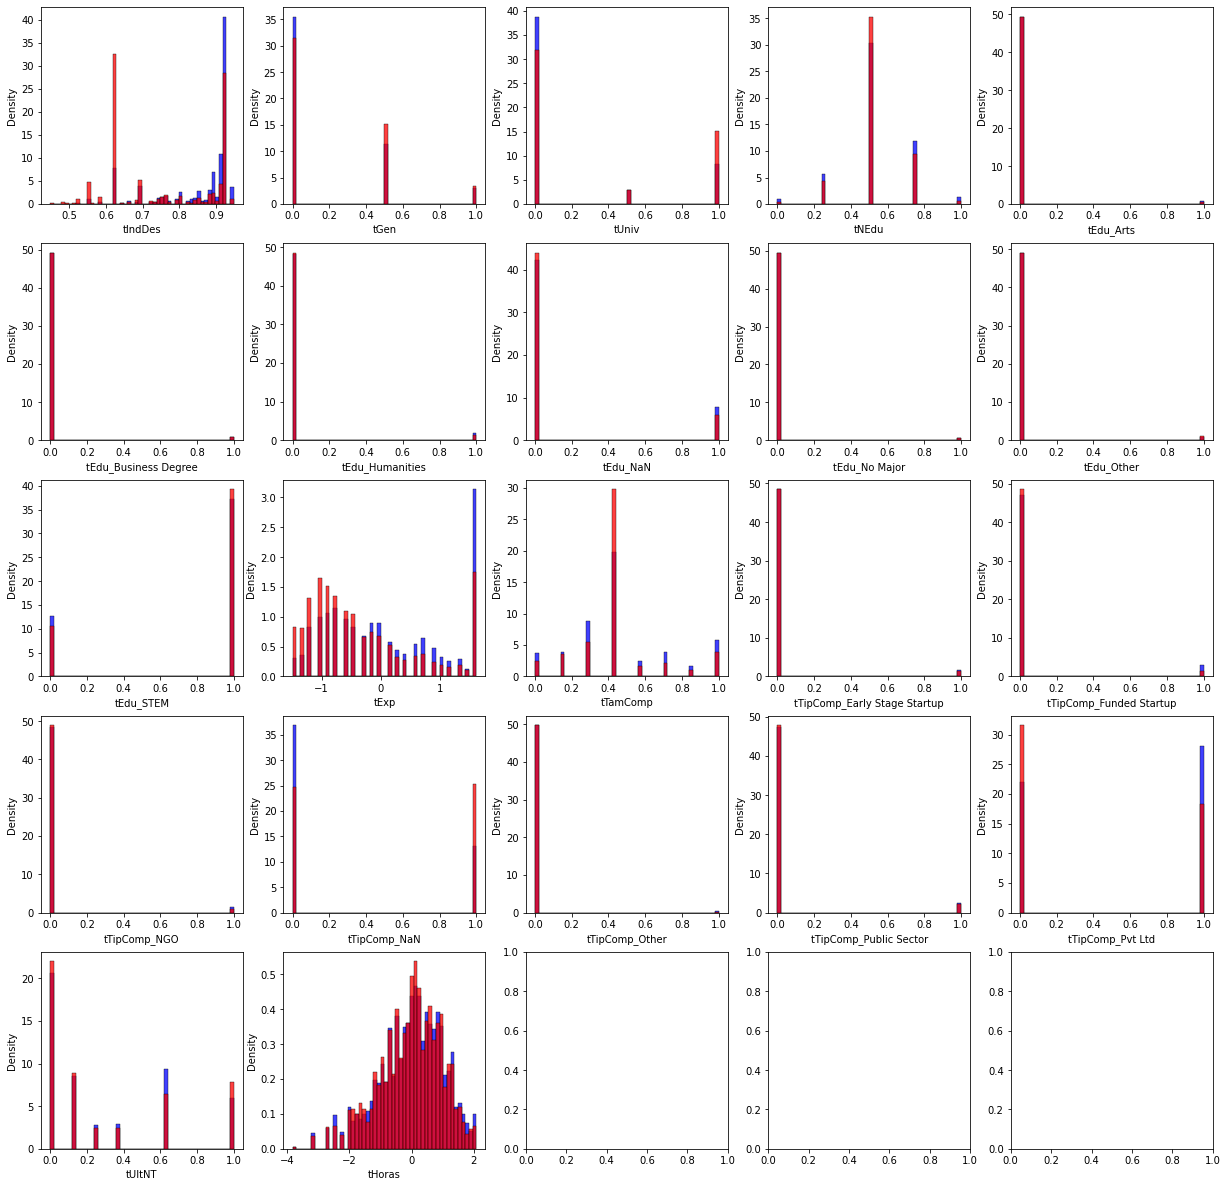

In [75]:
temp = df_dc_train_FT.copy()
temp['target'] = y_train
hist_class(temp, 'target')

## Prueba de dos modelos con el pipeline normal

In [76]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, solver='newton-cg' )
clf.fit(df_dc_train_FT, y_train)

LogisticRegression(random_state=0, solver='newton-cg')

In [77]:
print('Porcentaje acierto en train = %5.2f' % (clf.score(df_dc_train_FT, y_train)*100),'%')
print('Porcentaje acierto en test = %5.2f' % (clf.score(df_dc_test_FT, y_test)*100),'%')

Porcentaje acierto en train = 76.75 %
Porcentaje acierto en test = 76.49 %


In [78]:
from sklearn.ensemble import ExtraTreesClassifier

cet = ExtraTreesClassifier(n_estimators=100, random_state=0)
cet.fit(df_dc_train_FT, y_train)

ExtraTreesClassifier(random_state=0)

In [79]:
print('Porcentaje acierto en train = %5.2f' % (cet.score(df_dc_train_FT, y_train)*100),'%')
print('Porcentaje acierto en test = %5.2f' % (cet.score(df_dc_test_FT, y_test)*100),'%')

Porcentaje acierto en train = 99.82 %
Porcentaje acierto en test = 76.83 %


##  Optimizacion con Grid Search con cv de 5 

In [80]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)

In [81]:
s_data_pipe = ('data_pipe',data_pipe)
model = ('clf_LR', LogisticRegression())
full_pipe = Pipeline([s_data_pipe, model])

In [82]:
alphas = np.logspace(-4., 0, 30)
params_pipe = {'clf_LR__C': alphas}

In [83]:
from sklearn.model_selection import GridSearchCV
clf_LR_gs = GridSearchCV(estimator=full_pipe,
                         param_grid=params_pipe,
                         cv=skf,
                         scoring='accuracy')
#                         scoring='roc_auc' )
#                         scoring='average_precision' ) 

In [84]:
clf_LR_gs.fit(X_train, y_train)   ## Ojo con no darle el X_train ya transformado... horas buscando un error inexistente
df_cv_results = pd.DataFrame(clf_LR_gs.cv_results_)
df_cv_results.sort_values('rank_test_score', axis=0, ascending=True).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf_LR__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
29,0.134201,0.011348,0.019585,0.000588,1.0,{'clf_LR__C': 1.0},0.768102,0.764111,0.772268,0.768679,0.760196,0.766671,0.004144,1
26,0.132474,0.012610,0.020504,0.001506,0.385662,{'clf_LR__C': 0.38566204211634725},0.766797,0.764763,0.771941,0.768679,0.759543,0.766345,0.004141,2
28,0.132186,0.003656,0.020115,0.000877,0.727895,{'clf_LR__C': 0.7278953843983146},0.767123,0.763785,0.771941,0.769005,0.759869,0.766345,0.004183,3
24,0.110028,0.003609,0.018958,0.000599,0.204336,{'clf_LR__C': 0.20433597178569418},0.766471,0.765090,0.770636,0.768352,0.760196,0.766149,0.003512,4
25,0.123660,0.011610,0.020125,0.001218,0.280722,{'clf_LR__C': 0.2807216203941176},0.767123,0.764111,0.771289,0.767047,0.760522,0.766018,0.003575,5


## Optimizacion con Grid Search y ejemplo de meter la codificacion como un hiperparametro más

Para que la codificacion sea un hiperparametro más necesitamos crear el pipeline con esa flexibilidad (dejando el tipo en blanco al crear la clase).

### Pipeline para optimizar ejemplo con log o eq en indice de desarrollo

In [85]:
trans_IndDes2 = ('tIndDes', tIndDes())  ### NO LE DOY EL TIPO

## Estas las dejo como estaban
#trans_tGen = ('tGen', tGen(tipo='0.5'))   ## posibles 'des', '0.5'
#trans_tExpRel = ('tExpRel', tExpRel(tipo='c_v')) ## posibles 'c_v' ## posibles 'c_v' --> # __posible solo 'des' no 'c_v'__
#trans_tUni = ('tUniversidad', tUniversidad(tipo='c_v_NaN_median')) ## posibles 'c_v', 'c_v_NaN_median'
#trans_tNEdu = ('tNEducacion', tNEducacion(tipo='c_v_NaN_median')) ## posibles 'c_v', 'c_v_NaN_median'
#trans_tEdu = ('tEdu', tEdu(tipo='One-Hot'))   ## posibles 'des' 'One-Hot'
#trans_tExp = ('tExperiencia', tExperiencia(tipo='to_num_NaN_median')) ## posibles 'to_num', 'to_num_NaN_median'
#trans_tTamComp = ('tTamComp', tTamComp(tipo='c_v_NaN_median')) ## posibles 'des','c_v','des_c_v', 'c_v_NaN_median' solo el ultimo sentido
#trans_tTipComp = ('tTipComp', tTipComp(tipo='One-Hot'))   ## posibles 'des', 'One-Hot'
#trans_tUltNT = ('tUltNT', tUltNT(tipo='c_v_NaN_median')) ## posibles 'c_v', 'c_v_NaN_median'

#columns_to_drop = ['empleado_id', 'ciudad', 'genero',
#       'experiencia_relevante', 'universidad_matriculado', 'nivel_educacion',
#       'educacion', 'experiencia', 'tamano_compania', 'tipo_compania',
#       'ultimo_nuevo_trabajo']

#trans_Drop = ('DropColumns', DropColumns(columns_to_drop))

### AHORA USO LA 2 PARA OPTIMIZAR
pipe_steps = [trans_IndDes2, trans_tGen, trans_tUni, trans_tNEdu, trans_tEdu, #--> falta tExpRel & tHoras
             trans_tExp, trans_tTamComp, trans_tTipComp, trans_tUltNT, trans_Drop]
### Creo el objeto Pipeline
data_pipe2 = Pipeline(pipe_steps)


In [39]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)

In [40]:
s_data_pipe2 = ('data_pipe',data_pipe2)
model = ('clf_ET', ExtraTreesClassifier(n_jobs=-1))
full_pipe2 = Pipeline([s_data_pipe2, model])

### Aqui esta la gracia, si no se los parametros uso clf_ET_gs.estimator.get_params().keys() para ver los que tengo

In [117]:
params_pipe = {'data_pipe__tIndDes__tipo': ['eq','log'],
               'clf_ET__n_estimators': [ 90, 100],
              'clf_ET__criterion': ['gini', 'entropy'],
              'clf_ET__min_samples_split': [2, 3, 5],
              }

In [118]:
from sklearn.model_selection import GridSearchCV
clf_ET_gs = GridSearchCV(estimator=full_pipe2,
                         param_grid=params_pipe,
                         cv=skf,
                         scoring='accuracy')
#                         scoring='roc_auc' )
#                         scoring='average_precision' ) 

In [119]:
clf_ET_gs.estimator.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'data_pipe', 'clf_ET', 'data_pipe__memory', 'data_pipe__steps', 'data_pipe__verbose', 'data_pipe__tIndDes', 'data_pipe__tGen', 'data_pipe__tUniversidad', 'data_pipe__tNEducacion', 'data_pipe__tEdu', 'data_pipe__tExperiencia', 'data_pipe__tTamComp', 'data_pipe__tTipComp', 'data_pipe__tUltNT', 'data_pipe__DropColumns', 'clf_ET__bootstrap', 'clf_ET__ccp_alpha', 'clf_ET__class_weight', 'clf_ET__criterion', 'clf_ET__max_depth', 'clf_ET__max_features', 'clf_ET__max_leaf_nodes', 'clf_ET__max_samples', 'clf_ET__min_impurity_decrease', 'clf_ET__min_impurity_split', 'clf_ET__min_samples_leaf', 'clf_ET__min_samples_split', 'clf_ET__min_weight_fraction_leaf', 'clf_ET__n_estimators', 'clf_ET__n_jobs', 'clf_ET__oob_score', 'clf_ET__random_state', 'clf_ET__verbose', 'clf_ET__warm_start'])

In [120]:
clf_ET_gs.fit(X_train, y_train)   ## Ojo con no darle el X_train ya transformado... horas buscando un error inexistente
df_cv_results = pd.DataFrame(clf_ET_gs.cv_results_)
df_cv_results.sort_values('rank_test_score', axis=0, ascending=True).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf_ET__criterion,param_clf_ET__min_samples_split,param_clf_ET__n_estimators,param_data_pipe__tIndDes__tipo,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,0.444013,0.012415,0.057047,0.002221,gini,5,100,log,"{'clf_ET__criterion': 'gini', 'clf_ET__min_sam...",0.787345,0.786297,0.777162,0.766069,0.773899,0.778154,0.007949,1
22,0.464358,0.011995,0.062832,0.004967,entropy,5,100,eq,"{'clf_ET__criterion': 'entropy', 'clf_ET__min_...",0.781148,0.784013,0.782708,0.767374,0.768679,0.776784,0.007220,2
9,0.432642,0.017541,0.059241,0.002646,gini,5,90,log,"{'clf_ET__criterion': 'gini', 'clf_ET__min_sam...",0.782779,0.782708,0.783361,0.765742,0.765742,0.776066,0.008433,3
10,0.456779,0.017786,0.061036,0.005550,gini,5,100,eq,"{'clf_ET__criterion': 'gini', 'clf_ET__min_sam...",0.788324,0.782708,0.776835,0.761175,0.770310,0.775870,0.009483,4
21,0.438627,0.030502,0.063430,0.011381,entropy,5,90,log,"{'clf_ET__criterion': 'entropy', 'clf_ET__min_...",0.784083,0.781077,0.782382,0.763785,0.767374,0.775740,0.008428,5


Vemos que el Grid Search dice que la mejor forma de tratar esta variable es con la codificacion 'log' además de darme las otras variables optimas del modelo. 

# Parte Paula

## Creacion del Pipeline

Ya tengo todas las clases definidas ahora creo el pipeline de tratamiento de datos.

In [86]:
from sklearn.pipeline import Pipeline

In [88]:
trans_IndDes = ('tIndDes', tIndDes(tipo='eq'))  ##  posibles 'eq', 'log'
trans_tGen = ('tGen', tGen(tipo='0.5'))   ## posibles 'des', '0.5'
trans_tExpRel = ('tExpRel', tExpRel(tipo='des')) ## posibles 'des'
trans_tUni = ('tUniversidad', tUniversidad(tipo='c_vN_NaN_median')) ## posibles 'c_v', 'c_v_NaN_median'
trans_tNEdu = ('tNEducacion', tNEducacion(tipo='c_vN_NaN_median')) ## posibles 'c_v', 'c_v_NaN_median'
trans_tEdu = ('tEdu', tEdu(tipo='One-Hot'))   ## posibles 'des' 'One-Hot'
trans_tExp = ('tExperiencia', tExperiencia(tipo='to_num_NaN_medianSS')) ## posibles 'to_num', 'to_num_NaN_median'
trans_tTamComp = ('tTamComp', tTamComp(tipo='c_vN_NaN_median')) ## posibles 'des','c_v','des_c_v', 'c_v_NaN_median' solo el ultimo sentido
trans_tTipComp = ('tTipComp', tTipComp(tipo='One-Hot'))   ## posibles 'des', 'One-Hot'
trans_tUltNT = ('tUltNT', tUltNT(tipo='c_vN_NaN_median')) ## posibles 'c_v', 'c_v_NaN_median'
trans_tHoras = ('tHoras', tHoras(tipo='logSS'))

columns_to_drop = ['empleado_id', 'ciudad', 'indice_desarrollo_ciudad', 'genero',
       'experiencia_relevante', 'universidad_matriculado', 'nivel_educacion',
       'educacion', 'experiencia', 'tamano_compania', 'tipo_compania',
       'ultimo_nuevo_trabajo', 'horas_formacion']

trans_Drop = ('DropColumns', DropColumns(columns_to_drop))

### Lista de operaciones
pipe_steps = [trans_IndDes, trans_tGen, trans_tExpRel, trans_tUni, trans_tNEdu, trans_tEdu, 
             trans_tExp, trans_tTamComp, trans_tTipComp, trans_tUltNT, trans_tHoras, trans_Drop]
### Creo el objeto Pipeline
data_pipe = Pipeline(pipe_steps)


df_dc_train_FT = data_pipe.fit_transform(X_train)
df_dc_test_FT = data_pipe.transform(X_test)

In [89]:
df_dc_train_FT.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15326 entries, 14438 to 10510
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tIndDes                       15326 non-null  float64
 1   tGen                          15326 non-null  float64
 2   tUniv                         15326 non-null  float64
 3   tNEdu                         15326 non-null  float64
 4   tEdu_Arts                     15326 non-null  float64
 5   tEdu_Business Degree          15326 non-null  float64
 6   tEdu_Humanities               15326 non-null  float64
 7   tEdu_NaN                      15326 non-null  float64
 8   tEdu_No Major                 15326 non-null  float64
 9   tEdu_Other                    15326 non-null  float64
 10  tEdu_STEM                     15326 non-null  float64
 11  tExp                          15326 non-null  float64
 12  tTamComp                      15326 non-null  float64
 1

## Información general sobre el comportamiento de modelos de clasificación

* Pruebo algunos modelos con un conjunto de features normal 
* utilizando un código de machinelearningmastery, pero lo configuro para usarlo para mis objectivo.
* El objetivo es decir qué modelo puede tratar las Características con alta accuracy, para elegir los mejores modelos para optimizaciones adicionales.
https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation/


>LogisticRegression: cv=0.768
>RidgeClassifier: cv=0.766
>SGDClassifier: cv=0.760
>PassiveAggressiveClassifier: cv=0.692
>KNeighborsClassifier: cv=0.735
>DecisionTreeClassifier: cv=0.711
>ExtraTreeClassifier: cv=0.709
>LinearSVC: cv=0.767
>SVC: cv=0.762
>GaussianNB: cv=0.721
>AdaBoostClassifier: cv=0.774
>BaggingClassifier: cv=0.769
>RandomForestClassifier: cv=0.781
>GradientBoostingClassifier: cv=0.787
>LinearDiscriminantAnalysis: cv=0.770
>QuadraticDiscriminantAnalysis: cv=0.608


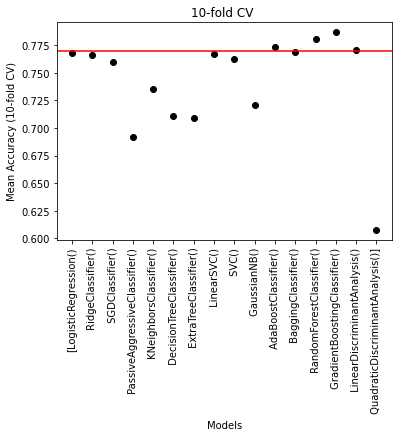

In [90]:
from numpy import mean
from numpy import isnan
from numpy import asarray
from matplotlib import pyplot
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
 
# create the dataset
def get_dataset():
    X = df_dc_train_FT
    y = y_train
    return X, y
 
# get a list of models to evaluate
def get_models():
	models = list()
	models.append(LogisticRegression())
	models.append(RidgeClassifier())
	models.append(SGDClassifier())
	models.append(PassiveAggressiveClassifier())
	models.append(KNeighborsClassifier())
	models.append(DecisionTreeClassifier())
	models.append(ExtraTreeClassifier())
	models.append(LinearSVC())
	models.append(SVC())
	models.append(GaussianNB())
	models.append(AdaBoostClassifier())
	models.append(BaggingClassifier())
	models.append(RandomForestClassifier())
	models.append(GradientBoostingClassifier())
	models.append(LinearDiscriminantAnalysis())
	models.append(QuadraticDiscriminantAnalysis())
	return models
 
# evaluate the model using a given test condition
def evaluate_model(cv, model):
	# get the dataset
	X, y = get_dataset()
	# evaluate the model
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	# return scores
	return mean(scores)
 
# define validation conditions
cv = KFold(n_splits=10, shuffle=True, random_state=1)
# get the list of models to consider
models = get_models()
# collect results
cv_results = list()
# evaluate each model
for model in models:
# evaluate model using each test condition
    cv_mean = evaluate_model(cv, model)
# check for invalid results
    if isnan(cv_mean):
        continue
# store results
    cv_results.append(cv_mean)
# summarize progress
    print('>%s: cv=%.3f' % (type(model).__name__, cv_mean))
# plot of results
modelos = str(models).split(',')
pyplot.plot(modelos, cv_results,'o', color='black')
plt.axhline(y=0.77, color='r', linestyle='-')
plt.xticks(rotation='vertical')

# label the plot
pyplot.title('10-fold CV ')
pyplot.ylabel('Mean Accuracy (10-fold CV)')
pyplot.xlabel('Models')
pyplot.show()

## Featuresselection for best models with an accuracy over 0.77 
### Breve explicación del los modelos 

En el comparación de modelos con features elejido de liberdad podemos identificar 3 modelos de ensambling, que muestran un resultado de accuracy mas de 0.77

* __RandomForest:__
  * La cantidad de datos se divide al azar y se crea un árbol de decisiones a partir de cada división. 
  * Una decisión mayoritaria para las clasificaciones de todos los árboles es el aprendizaje 'ensambling' del RandomForest.


* __Dos modelos de Boosting "AdaboostClassifier" y "GradientBoostingClassifier"__
* Los problemas complejos se pueden implementar con clasificadores más débiles (como árboles de decisión con una sola división, que se denominan tocones de decisión debido a su cortedad) mediante el Boosting, en el que un algoritmo debil se entrena en varias ejecuciones con adapicon de los pesos.

* AdaBoostingClasifier
  * AdaBoost funciona pesando las observaciones
  * El primer paso es el entrenamiento de arboles de decision es normal. Las pruebas posteriores demonstran errores de clasificación. Los datos predichos incorrectamente se pesandos con pesos más alto para la siguiente iteracion. Esta iteración se ejecuta varias veces hasta que el error ya no mejora.


* GradientBoostingClasifier
  * La alternativa del AdaBoosting, es el GradientBoostingClasifier basado en el método de gradiente. Los pesos se ajustan explícitamente en la dirección opuesta al error de predicción (Backpropagation).


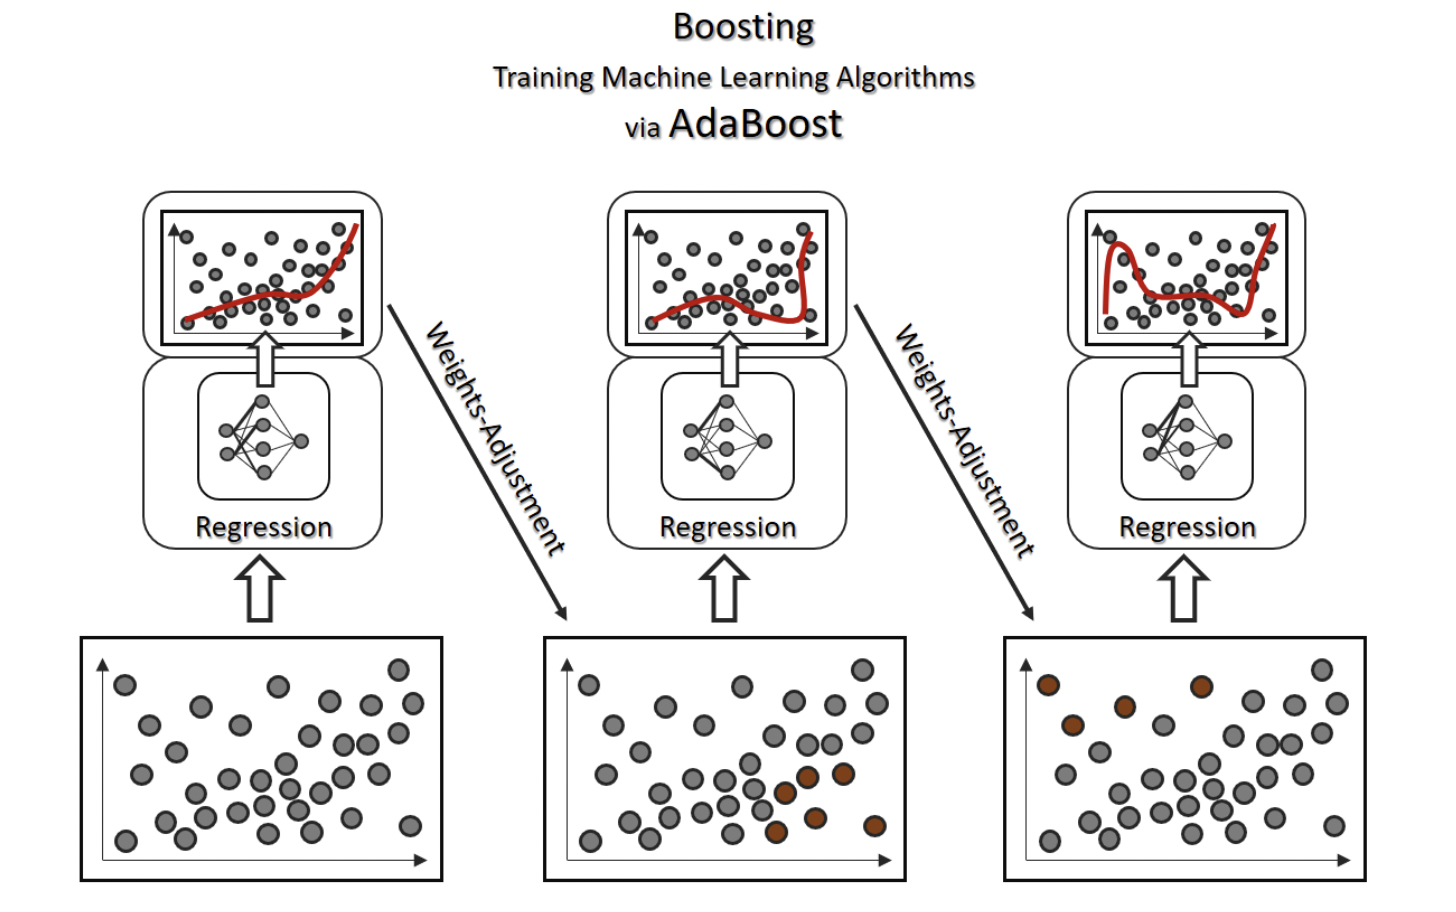


Referencia: https://data-science-blog.com/blog/2017/12/03/ensemble-learning/


### Featureselection

* Con un Gridsearch sobre las features de sus transformaciones y los modelos decididos (sin ajuste fino), verifico si hay transformaciones de features óptimas.
* Después de cada gridsearch de modelos, puedo comprobar los resultados y verifico si hay tendencias iguales por los modelos.

In [108]:
trans_IndDes2 = ('tIndDes', tIndDes())  ### NO LE DOY EL TIPO
trans_tGen2 =('tGen', tGen('0.5'))
trans_tExpRel2 =('tExpRel', tExpRel(tipo='des'))
trans_tUni2=('tUniversidad',tUniversidad())
trans_tNEdu2=('tNEducacion', tNEducacion())
trans_tEdu2 = ('tEdu', tEdu(tipo='One-Hot'))
trans_tExp2=('tExperiencia', tExperiencia())
trans_tTamComp2=('tTamComp', tTamComp())
trans_tTipComp2 = ('tTipComp',tTipComp())
trans_tUltNT2 = ('tUltNT',tUltNT())
trans_tHoras2 = ('tHoras', tHoras())

pipe_steps = [trans_IndDes2, trans_tGen2, trans_tExpRel2, trans_tUni2, trans_tNEdu2, trans_tEdu2, 
             trans_tExp2, trans_tTamComp2, trans_tTipComp2, trans_tUltNT2, trans_tHoras2, trans_Drop]


data_pipe2 = Pipeline(pipe_steps)



In [109]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)

### 1. GradientBoostingClassifier


In [110]:
s_data_pipe2 = ('data_pipe',data_pipe2)
model = ('clf_GBC', GradientBoostingClassifier())
full_pipe2 = Pipeline([s_data_pipe2, model])

In [111]:
params_pipe = {'data_pipe__tIndDes__tipo': ['eq','log'],
              'data_pipe__tUniversidad__tipo': ['c_v', 'c_vN_NaN_median', 'c_v_NaN_median'],
              'data_pipe__tNEducacion__tipo': ['c_v', 'c_v_NaN_median', 'c_vN_NaN_median'],
               'data_pipe__tExperiencia__tipo': ['to_num', 'to_num_NaN_median'],
               'data_pipe__tTamComp__tipo': ['des' ,'c_v',  'des_c_v' , 'c_v_NaN_median',  'c_vN_NaN_median', 'c_v_NaN_medianSS'],
               'data_pipe__tTipComp__tipo': ['des', 'One-Hot'],
               'data_pipe__tUltNT__tipo': ['c_v', 'c_v_NaN_median', 'c_vN_NaN_median'],
               'data_pipe__tHoras__tipo': ['eq', 'eqSS' , 'log', 'logSS']
              }

In [112]:
from sklearn.model_selection import GridSearchCV
clf_GBC_gs = GridSearchCV(estimator=full_pipe2,
                         param_grid=params_pipe,
                         cv=skf,
                         scoring='accuracy')
#                         scoring='roc_auc' )
#                         scoring='average_precision' ) 

In [113]:
clf_GBC_gs.fit(X_train, y_train)   ## Ojo con no darle el X_train ya transformado... horas buscando un error inexistente
df_cv_results = pd.DataFrame(clf_GBC_gs.cv_results_)
#df_cv_results.sort_values('rank_test_score', axis=0, ascending=True).head()

In [114]:
pd.set_option('display.max_columns', None)
df_cv_results.sort_values('rank_test_score', axis=0, ascending=True).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_data_pipe__tExperiencia__tipo,param_data_pipe__tHoras__tipo,param_data_pipe__tIndDes__tipo,param_data_pipe__tNEducacion__tipo,param_data_pipe__tTamComp__tipo,param_data_pipe__tTipComp__tipo,param_data_pipe__tUltNT__tipo,param_data_pipe__tUniversidad__tipo,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3454,0.895752,0.017552,0.025463,0.001141,to_num_NaN_median,eqSS,eq,c_v_NaN_median,c_v_NaN_medianSS,One-Hot,c_vN_NaN_median,c_vN_NaN_median,{'data_pipe__tExperiencia__tipo': 'to_num_NaN_...,0.78865,0.792496,0.787928,0.785971,0.783034,0.787616,0.00312,1
3112,0.876894,0.005789,0.025072,0.000458,to_num_NaN_median,eq,log,c_v_NaN_median,c_vN_NaN_median,One-Hot,c_vN_NaN_median,c_vN_NaN_median,{'data_pipe__tExperiencia__tipo': 'to_num_NaN_...,0.78865,0.792496,0.787928,0.785971,0.783034,0.787616,0.00312,1
3542,0.877541,0.006412,0.024574,0.000253,to_num_NaN_median,eqSS,eq,c_vN_NaN_median,c_vN_NaN_median,One-Hot,c_v_NaN_median,c_v_NaN_median,{'data_pipe__tExperiencia__tipo': 'to_num_NaN_...,0.78865,0.792496,0.787928,0.785971,0.783034,0.787616,0.00312,1
3758,0.868636,0.001704,0.024694,0.000056,to_num_NaN_median,eqSS,log,c_v_NaN_median,c_vN_NaN_median,One-Hot,c_v_NaN_median,c_v_NaN_median,{'data_pipe__tExperiencia__tipo': 'to_num_NaN_...,0.78865,0.792496,0.787928,0.785971,0.783034,0.787616,0.00312,1
2893,0.867341,0.002078,0.024419,0.000199,to_num_NaN_median,eq,eq,c_vN_NaN_median,c_vN_NaN_median,One-Hot,c_v_NaN_median,c_vN_NaN_median,{'data_pipe__tExperiencia__tipo': 'to_num_NaN_...,0.78865,0.792496,0.787928,0.785971,0.783034,0.787616,0.00312,1


In [115]:
s_data_pipe2 = ('data_pipe',data_pipe2)
model = ('clf_RF', RandomForestClassifier())
full_pipe2 = Pipeline([s_data_pipe2, model])

In [116]:
from sklearn.model_selection import GridSearchCV
clf_RF_gs = GridSearchCV(estimator=full_pipe2,
                         param_grid=params_pipe,
                         cv=skf,
                         scoring='accuracy')
#                         scoring='roc_auc' )
#                         scoring='average_precision' ) 

In [117]:
clf_RF_gs.fit(X_train, y_train)   ## Ojo con no darle el X_train ya transformado... horas buscando un error inexistente
df_cv_results2 = pd.DataFrame(clf_RF_gs.cv_results_)
#df_cv_results2.sort_values('rank_test_score', axis=0, ascending=True).head()

In [118]:
pd.set_option('display.max_columns', None)
df_cv_results2.sort_values('rank_test_score', axis=0, ascending=True).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_data_pipe__tExperiencia__tipo,param_data_pipe__tHoras__tipo,param_data_pipe__tIndDes__tipo,param_data_pipe__tNEducacion__tipo,param_data_pipe__tTamComp__tipo,param_data_pipe__tTipComp__tipo,param_data_pipe__tUltNT__tipo,param_data_pipe__tUniversidad__tipo,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4517,0.796946,0.003582,0.069510,0.000142,to_num_NaN_median,log,log,c_vN_NaN_median,c_vN_NaN_median,One-Hot,c_vN_NaN_median,c_v_NaN_median,{'data_pipe__tExperiencia__tipo': 'to_num_NaN_...,0.791585,0.787602,0.783687,0.771615,0.776835,0.782265,0.007215,1
3760,0.796010,0.002048,0.069279,0.000177,to_num_NaN_median,eqSS,log,c_v_NaN_median,c_vN_NaN_median,One-Hot,c_vN_NaN_median,c_vN_NaN_median,{'data_pipe__tExperiencia__tipo': 'to_num_NaN_...,0.793542,0.789233,0.783034,0.772920,0.772594,0.782265,0.008452,2
2878,0.792429,0.003907,0.068695,0.000253,to_num_NaN_median,eq,eq,c_vN_NaN_median,c_v_NaN_median,One-Hot,c_vN_NaN_median,c_vN_NaN_median,{'data_pipe__tExperiencia__tipo': 'to_num_NaN_...,0.789628,0.789233,0.788254,0.767700,0.776183,0.782200,0.008806,3
4405,0.797434,0.003452,0.069617,0.000184,to_num_NaN_median,log,log,c_v_NaN_median,c_vN_NaN_median,One-Hot,c_v_NaN_median,c_vN_NaN_median,{'data_pipe__tExperiencia__tipo': 'to_num_NaN_...,0.793216,0.789560,0.779119,0.775204,0.773899,0.782199,0.007783,4
5164,0.799042,0.003090,0.070074,0.000122,to_num_NaN_median,logSS,log,c_vN_NaN_median,c_vN_NaN_median,One-Hot,c_vN_NaN_median,c_vN_NaN_median,{'data_pipe__tExperiencia__tipo': 'to_num_NaN_...,0.794847,0.787602,0.781729,0.774551,0.772268,0.782199,0.008325,5


In [119]:
AdaBoostClassifier

sklearn.ensemble._weight_boosting.AdaBoostClassifier

In [120]:
s_data_pipe2 = ('data_pipe',data_pipe2)
model = ('clf_ABC', AdaBoostClassifier())
full_pipe2 = Pipeline([s_data_pipe2, model])

In [121]:
from sklearn.model_selection import GridSearchCV
clf_ABC_gs = GridSearchCV(estimator=full_pipe2,
                         param_grid=params_pipe,
                         cv=skf,
                         scoring='accuracy')
#                         scoring='roc_auc' )
#                         scoring='average_precision' ) 

In [122]:
clf_ABC_gs.fit(X_train, y_train)   ## Ojo con no darle el X_train ya transformado... horas buscando un error inexistente
df_cv_results3 = pd.DataFrame(clf_RF_gs.cv_results_)
#df_cv_results3.sort_values('rank_test_score', axis=0, ascending=True).head()

In [123]:
pd.set_option('display.max_columns', None)
df_cv_results3.sort_values('rank_test_score', axis=0, ascending=True).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_data_pipe__tExperiencia__tipo,param_data_pipe__tHoras__tipo,param_data_pipe__tIndDes__tipo,param_data_pipe__tNEducacion__tipo,param_data_pipe__tTamComp__tipo,param_data_pipe__tTipComp__tipo,param_data_pipe__tUltNT__tipo,param_data_pipe__tUniversidad__tipo,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4517,0.796946,0.003582,0.069510,0.000142,to_num_NaN_median,log,log,c_vN_NaN_median,c_vN_NaN_median,One-Hot,c_vN_NaN_median,c_v_NaN_median,{'data_pipe__tExperiencia__tipo': 'to_num_NaN_...,0.791585,0.787602,0.783687,0.771615,0.776835,0.782265,0.007215,1
3760,0.796010,0.002048,0.069279,0.000177,to_num_NaN_median,eqSS,log,c_v_NaN_median,c_vN_NaN_median,One-Hot,c_vN_NaN_median,c_vN_NaN_median,{'data_pipe__tExperiencia__tipo': 'to_num_NaN_...,0.793542,0.789233,0.783034,0.772920,0.772594,0.782265,0.008452,2
2878,0.792429,0.003907,0.068695,0.000253,to_num_NaN_median,eq,eq,c_vN_NaN_median,c_v_NaN_median,One-Hot,c_vN_NaN_median,c_vN_NaN_median,{'data_pipe__tExperiencia__tipo': 'to_num_NaN_...,0.789628,0.789233,0.788254,0.767700,0.776183,0.782200,0.008806,3
4405,0.797434,0.003452,0.069617,0.000184,to_num_NaN_median,log,log,c_v_NaN_median,c_vN_NaN_median,One-Hot,c_v_NaN_median,c_vN_NaN_median,{'data_pipe__tExperiencia__tipo': 'to_num_NaN_...,0.793216,0.789560,0.779119,0.775204,0.773899,0.782199,0.007783,4
5164,0.799042,0.003090,0.070074,0.000122,to_num_NaN_median,logSS,log,c_vN_NaN_median,c_vN_NaN_median,One-Hot,c_vN_NaN_median,c_vN_NaN_median,{'data_pipe__tExperiencia__tipo': 'to_num_NaN_...,0.794847,0.787602,0.781729,0.774551,0.772268,0.782199,0.008325,5


In [226]:
r3 = pd.DataFrame(df_cv_results3.sort_values('rank_test_score', axis=0, ascending=True).head(1))
r2 = pd.DataFrame(df_cv_results2.sort_values('rank_test_score', axis=0, ascending=True).head(1))
r1 = pd.DataFrame(df_cv_results.sort_values('rank_test_score', axis=0, ascending=True).head(1))

In [227]:
compare = pd.concat([r1,r2,r3])
compare

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_data_pipe__tExperiencia__tipo,param_data_pipe__tHoras__tipo,param_data_pipe__tIndDes__tipo,param_data_pipe__tNEducacion__tipo,param_data_pipe__tTamComp__tipo,param_data_pipe__tTipComp__tipo,param_data_pipe__tUltNT__tipo,param_data_pipe__tUniversidad__tipo,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4751,1.311074,0.003255,0.027065,0.000073,to_num_NaN_median,logSS,eq,c_v_NaN_median,c_v_NaN_medianSS,One-Hot,c_vN_NaN_median,c_v_NaN_median,{'data_pipe__tExperiencia__tipo': 'to_num_NaN_...,0.793542,0.795106,0.792822,0.782382,0.780098,0.788790,0.006251,1
4517,0.796946,0.003582,0.069510,0.000142,to_num_NaN_median,log,log,c_vN_NaN_median,c_vN_NaN_median,One-Hot,c_vN_NaN_median,c_v_NaN_median,{'data_pipe__tExperiencia__tipo': 'to_num_NaN_...,0.791585,0.787602,0.783687,0.771615,0.776835,0.782265,0.007215,1
4517,0.796946,0.003582,0.069510,0.000142,to_num_NaN_median,log,log,c_vN_NaN_median,c_vN_NaN_median,One-Hot,c_vN_NaN_median,c_v_NaN_median,{'data_pipe__tExperiencia__tipo': 'to_num_NaN_...,0.791585,0.787602,0.783687,0.771615,0.776835,0.782265,0.007215,1


__Resumen:__
* La clasifier de de AdaBoosting y de RandomForest tienen las mismas transformaciones de features.
* uniquo el modelo de GradientBoostingClassifier tiene diferente settings de Featureset.

__Con estos Feature Settings voy a optimizar los modelos con una Grid Search de Hiperparámetros y validación cruzada de StratifiedKFolder en el entrenamiento. De mas utilizo una metoda de oversampling con SMOTE por los datos de train_transformado__

## Describción de tranformaciones de las variables


__indice_desarrollo_ciudad__
 *   eq - lo deja igual, pero es para crear la columna t... así no condicionamos el drop columns    
 *   log - log de la variable
    
__genero__
  *  0.5 - NaN y Others a 0.5   
  *  0.3 - NaN y Others a 0.3

__experiencia_relevante__
   * c_v - 1 o 0 según tiene o no experiencia

__universidad_matriculado__
  *  c_v_NaN_median - 0, 1, 2 según si esta estudiando + NaN a mediana
  *  c_vN_NaN_median - 0, 0.5, 1 (clave valor ahora definido de 0 a 1 ¡¡¡más lógico!!!) según si esta 
                                    estudiando + NaN a mediana
                                    
__nivel_educacion__
  *  c_v_NaN_median - 1 a 5  según el nivel + NaN a mediana
  *  c_vN_NaN_median - 0, 0.5, 1 (clave valor ahora definido de 0 a 1 ¡¡¡más lógico!!!) según el nivel 
                                 + NaN a mediana
__educacion__
  * One-Hot  - pues eso, con los NaN en columna aparte
    
__experiencia__
   * to_num_NaN_median - de 0 a 21 con los NaN en mediana
   * to_num_NaN_medianSS - de 0 a 21 con los NaN en media y hacemos un StandardScaler
   * to_num_NaN_medianQT - de 0 a 21 con los NaN en media y hacemos un QuantileTransformer para que la                            salida sea una normal
         
__tamano_compania__
   * c_v_NaN_median - de 1 a 8 mas NaN median
   * c_vN_NaN_median - de 0 a 1 mas NaN median    
   * c_v_NaN_medianSS - de 1 a 8 mas NaN median mas StandardScaler
    
__tipo_compania__
   * One-Hot  - pues eso, con los NaN en columna aparte

__ultimo_nuevo_trabajo__
   * c_v_NaN_median  - de 1 a 9 mas NaN median
   * c_vN_NaN_median - de 0 a 1 mas NaN median 


    
__horas_formacion__
   * eq - lo deja igual, pero es para crear la columna t... así no condicionamos el drop columns  
  *  eqSS - igual mas StandardScaler
   * log - log de la variable
   * logSS - log mas StandardScaler




## Featureselection para GradientBoostingClassifier

In [228]:
trans_IndDes = ('tIndDes', tIndDes(tipo='eq')) ## la variable no contiene una transformacion
trans_tGen = ('tGen', tGen(tipo='0.5'))   # transformacion de genero en 0=male, 0.5=other /deconocido, 1 = female
trans_tExpRel = ('tExpRel', tExpRel(tipo='des')) # tranformacion binario
trans_tUni = ('tUniversidad', tUniversidad(tipo='c_vN_NaN_median')) #0 = no enrollment, 0.5 part_time, 1 full time / missing values llena con mediana
trans_tNEdu = ('tNEducacion', tNEducacion(tipo='c_v_NaN_median'))  #tranformacion en 
trans_tEdu = ('tEdu', tEdu(tipo='One-Hot'))   
trans_tExp = ('tExperiencia', tExperiencia(tipo='to_num_NaN_median')) 
trans_tTamComp = ('tTamComp', tTamComp(tipo='c_v_NaN_medianSS')) 
trans_tTipComp = ('tTipComp', tTipComp(tipo='One-Hot'))   
trans_tUltNT = ('tUltNT', tUltNT(tipo='c_vN_NaN_median')) 
trans_tHoras = ('tHoras', tHoras('eqSS'))

columns_to_drop = ['empleado_id', 'ciudad', 'genero',
       'experiencia_relevante', 'universidad_matriculado', 'nivel_educacion',
       'educacion', 'experiencia', 'tamano_compania', 'tipo_compania',
       'ultimo_nuevo_trabajo']

trans_Drop = ('DropColumns', DropColumns(columns_to_drop))

### Lista de operaciones
pipe_steps = [trans_IndDes, trans_tGen, trans_tExpRel, trans_tUni, trans_tNEdu, trans_tEdu, 
             trans_tExp, trans_tTamComp, trans_tTipComp, trans_tUltNT,trans_tHoras, trans_Drop]
### Creo el objeto Pipeline
data_pipe = Pipeline(pipe_steps)

df_dc_train_FT = data_pipe.fit_transform(X_train)
df_dc_test_FT = data_pipe.transform(X_test)

In [229]:
X_train_prep = df_dc_train_FT.copy()
X_test_prep = df_dc_test_FT.copy()
y_test = y_test.copy()

## Training with Oversampling (smote) & Gridsearch para optimizar los modelos elejido

__Breve explicación de SMOTE - Oversampling__
* Synthetic Minority Oversampling TEchnique, o SMOTE 
* SMOTE es una variante de oversampling, en la que se intenta, en particular, evitar un posible overfitting sobre las copias exactas generadas de las observaciones de la clase minoritaria. 
* En lugar de replicar las observaciones, se generan artificialmente nuevas observaciones interpolando observaciones seleccionadas al azar de la clase minoritaria. 
* Al igual que con el oversampling, el número de nuevas observaciones depende del ratio de oversampling, que Smote () seleccionalo o el analista determina libremente.
* Las observaciones de la clase grande (clase mayoritaria) quedarse sin cambios.

Referencias: https://epub.ub.uni-muenchen.de/25525/1/BA_Kühn.pdf (trabajo fin de bachiller)

In [230]:
from imblearn.over_sampling import SMOTE
over_sampler = SMOTE()
X_res, y_res = over_sampler.fit_resample(X_train_prep, y_train)

### GradientBoostingClassifier

In [231]:
from sklearn.metrics import classification_report, average_precision_score, accuracy_score, confusion_matrix

In [232]:
params_pipe = {'n_estimators': [80, 100, 200],
              'criterion': ['friedman_mse', 'mse'],
              'learning_rate': [0.02, 0.05, 0.1, 0.2],
               'max_depth':[2,4,6]
              }

In [233]:
gbc_model = GradientBoostingClassifier(random_state=42)
clf_GBC_GS = GridSearchCV(gbc_model, param_grid=params_pipe, cv=skf,scoring='accuracy' ,n_jobs=-1)
clf_GBC_GS.fit(X_res,y_res)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=24, shuffle=True),
             estimator=GradientBoostingClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['friedman_mse', 'mse'],
                         'learning_rate': [0.02, 0.05, 0.1, 0.2],
                         'max_depth': [2, 4, 6],
                         'n_estimators': [80, 100, 200]},
             scoring='accuracy')

In [234]:
print(clf_GBC_GS.best_score_)
print()
print(clf_GBC_GS.best_params_)

0.857310264826317

{'criterion': 'mse', 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200}


In [235]:
y_pred_GBC = clf_GBC_GS.predict(X_test_prep)

In [236]:
print(classification_report(y_test,y_pred_GBC))
print()
print(accuracy_score(y_test, y_pred_GBC))
print()
print(confusion_matrix(y_test, y_pred_GBC, labels= [0,1]))

              precision    recall  f1-score   support

         0.0       0.86      0.87      0.87      2877
         1.0       0.60      0.57      0.58       955

    accuracy                           0.80      3832
   macro avg       0.73      0.72      0.72      3832
weighted avg       0.79      0.80      0.80      3832


0.7972338204592901

[[2513  364]
 [ 413  542]]


In [237]:
yhat = clf_GBC_GS.predict_proba(X_test_prep)
pos_probs_GBC_GS = yhat[:, 1]

In [238]:
ap_pr_GBC_GS = average_precision_score(y_true=y_test, y_score=pos_probs_GBC_GS)
print('average Precision: '+str(ap_pr_GBC_GS))

average Precision: 0.5606359071071128


__Resumen:__
* Con este método de ensambling obtengo una precisión del 79,72% 
* En general, la precisión media de la etiqueta 1 sigue el 56,06% y muestra un equilibrio entre las métricas de recall y precision (57% /60%)
* como podemos ver en la matriz de confusión,
    * Recall de target 1 (57 %): 413 (Falso Negativo) empleados, que buscan un nuevo trabajo, no están clasificados correctamente.
    * Presicion de traget 1(60%): 364 (FalsePositiv) empleados, que no buscan trabajo nuevo, están identificados como buscan. 
  

In [267]:
import pickle 
filename = "modelo_GBC.pkl"
pickle.dump(clf_GBC_GS, open(filename, 'wb'))

## Featureselection para AdaBoostClassifier y RandomForest

In [239]:
trans_IndDes1 = ('tIndDes', tIndDes(tipo='log')) 
trans_tGen1 = ('tGen', tGen(tipo='0.5'))   
trans_tExpRel1 = ('tExpRel', tExpRel(tipo='des')) 
trans_tUni1 = ('tUniversidad', tUniversidad(tipo='c_v_NaN_median')) 
trans_tNEdu1 = ('tNEducacion', tNEducacion(tipo='c_vN_NaN_median')) 
trans_tEdu1 = ('tEdu', tEdu(tipo='One-Hot'))   
trans_tExp1 = ('tExperiencia', tExperiencia(tipo='to_num_NaN_median')) 
trans_tTamComp1 = ('tTamComp', tTamComp(tipo='c_vN_NaN_median')) 
trans_tTipComp1 = ('tTipComp', tTipComp(tipo='One-Hot'))   
trans_tUltNT1 = ('tUltNT', tUltNT(tipo='c_vN_NaN_median')) 
trans_tHoras1 = ('tHoras', tHoras('log'))

columns_to_drop = ['empleado_id', 'ciudad', 'genero',
       'experiencia_relevante', 'universidad_matriculado', 'nivel_educacion',
       'educacion', 'experiencia', 'tamano_compania', 'tipo_compania',
       'ultimo_nuevo_trabajo']

trans_Drop = ('DropColumns', DropColumns(columns_to_drop))

### Lista de operaciones
pipe_steps = [trans_IndDes1, trans_tGen1, trans_tExpRel1, trans_tUni1, trans_tNEdu1, trans_tEdu1, 
             trans_tExp1, trans_tTamComp1, trans_tTipComp1, trans_tUltNT1,trans_tHoras1, trans_Drop]
### Creo el objeto Pipeline
data_pipe1 = Pipeline(pipe_steps)

X_train_prep1 = data_pipe1.fit_transform(X_train)
X_test_prep1 = data_pipe1.transform(X_test)
y_train1 = y_train.copy()


In [240]:
from imblearn.over_sampling import SMOTE
over_sampler = SMOTE()
X_res1, y_res1 = over_sampler.fit_resample(X_train_prep1, y_train1)

### RandomForestClassifier

In [241]:
params_pipe = {'n_estimators': [80, 90, 100, 200],
              'criterion': ['gini', 'entropy'],
               'max_depth':[2,4,6]
              }

In [242]:
rf_model = RandomForestClassifier(random_state=42)
clf_RF_GS = GridSearchCV(rf_model, param_grid=params_pipe, cv=skf,scoring='accuracy' ,n_jobs=-1)
clf_RF_GS.fit(X_res1,y_res1)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=24, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6],
                         'n_estimators': [80, 90, 100, 200]},
             scoring='accuracy')

In [243]:
print(clf_RF_GS.best_score_)
print()
print(clf_RF_GS.best_params_)

0.8143257502832981

{'criterion': 'gini', 'max_depth': 6, 'n_estimators': 90}


In [244]:
y_pred_RF = clf_RF_GS.predict(X_test_prep1)

In [245]:
print(classification_report(y_test,y_pred_RF))
print()
print(accuracy_score(y_test,y_pred_RF))
print()
print(confusion_matrix(y_test,y_pred_RF, labels= [0,1]))

              precision    recall  f1-score   support

         0.0       0.89      0.79      0.84      2877
         1.0       0.53      0.71      0.61       955

    accuracy                           0.77      3832
   macro avg       0.71      0.75      0.72      3832
weighted avg       0.80      0.77      0.78      3832


0.769572025052192

[[2270  607]
 [ 276  679]]


In [246]:
yhat = clf_RF_GS.predict_proba(X_test_prep1)
pos_probs_RF_GS = yhat[:, 1]

In [247]:
ap_pr_RF_GS = average_precision_score(y_true=y_test, y_score=pos_probs_RF_GS)
print('average Precision: '+str(ap_pr_RF_GS))

average Precision: 0.5356147065169246


__Resumen:__
* Con el modelo de RandomForest obtengo una precisión del 76,95%, que depende de tradeoff de prescion - recall.
* en general la average precisión  de la etiqueta 1 sigue 53.56%
* Como podemos ver en la matriz de confusión,
    * Recall de target 1: 276 (Falso Negativo) empleados, que buscan un nuevo trabajo, no están clasificados correctamente. 
    * Presicion de traget 1: 607 (FalsePositiv) empleados, que no buscan trabajo nuevo, no están identificados correctamente. 
* El RandomForest muestra la mejor Recall de los modelos con 71 %, pero de lo contrario la precision está baja con 53% 

In [269]:
import pickle 
filename = "modelo_RFC.pkl"
pickle.dump(clf_RF_GS, open(filename, 'wb'))

### AdaBoostClassifier

In [248]:
params_pipe = {'n_estimators': [50,80, 100, 120],
              'learning_rate': [ 0.1, 0.5, 1, 1.5],
               'algorithm': ['SAMME', 'SAMME.R']
              }

In [249]:
abc_model = AdaBoostClassifier(random_state=42)
clf_ABC_GS = GridSearchCV(abc_model, param_grid=params_pipe, cv=skf,scoring='accuracy' ,n_jobs=-1)
clf_ABC_GS.fit(X_res1,y_res1)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=24, shuffle=True),
             estimator=AdaBoostClassifier(random_state=42), n_jobs=-1,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'learning_rate': [0.1, 0.5, 1, 1.5],
                         'n_estimators': [50, 80, 100, 120]},
             scoring='accuracy')

In [250]:
print(clf_ABC_GS.best_score_)
print()
print(clf_ABC_GS.best_params_)

0.8436197240344459

{'algorithm': 'SAMME.R', 'learning_rate': 1.5, 'n_estimators': 100}


In [251]:
y_pred_ABC = clf_ABC_GS.predict(X_test_prep1)

In [252]:
print(classification_report(y_test,y_pred_ABC))
print()
print(accuracy_score(y_test,y_pred_ABC))
print()
print(confusion_matrix(y_test,y_pred_ABC, labels= [0,1]))

              precision    recall  f1-score   support

         0.0       0.82      0.90      0.86      2877
         1.0       0.58      0.40      0.47       955

    accuracy                           0.78      3832
   macro avg       0.70      0.65      0.66      3832
weighted avg       0.76      0.78      0.76      3832


0.7768789144050104

[[2598  279]
 [ 576  379]]


In [253]:
yhat = clf_ABC_GS.predict_proba(X_test_prep1)
pos_probs_ABC_GS = yhat[:, 1]

In [254]:
ap_pr_ABC_GS = average_precision_score(y_true=y_test, y_score=pos_probs_ABC_GS)
print('average Precision: '+str(ap_pr_ABC_GS))

average Precision: 0.5268454677675327


__Resumen:__
* Con el modelo de AdaBoostingClassifier obtengo una accurcay del 78% (las metricas prescion - recall muestran valores revés de RandomForest --> precision alta, recall baja).
* en general la average precisión  de la etiqueta 1 sigue 52.68%
* Como podemos ver en la matriz de confusión,
    * Recall de target 1: 576 (Falso Negativo) empleados, que buscan un nuevo trabajo, no están clasificados correctamente.
    * Presicion de traget 1: 279 (FalsePositiv) empleados, que no buscan trabajo nuevo, no están identificados como no buscan trabajo nuevo. 
* El AdaBoost muestra un Recall baja al contrario de Random Forest, pero la Recall y Precision de label 0, es el mejor de los modelos (Recall 90 %, Precision 82 %) 
* Pero nuestro objetivo es mejorar las metricas de label 1, sin desmejora mucho los de label 0

In [268]:
import pickle 
filename = "modelo_ABC.pkl"
pickle.dump(clf_ABC_GS, open(filename, 'wb'))

## Optimización del GradientBoostingClassifier con configuraciones en los features

En la optimización utilizo por los features
* tUniversidad,  tNEducacion, tTamCom el tipo 'c_v_NaN_median', que dice, todos los nulos tratando como mediana y la tranformacion está hecho con una escalera de números enteros. 
* y las horas de formación no he estandardizado ('eq')

Resultados:
* la precision es un poco mejor que en el último GBC, especialmente en la precision de la etiqueta 1 con falso positivo de 379 empleados (antes 395)

In [255]:
trans_IndDes3 = ('tIndDes', tIndDes(tipo='eq')) 
trans_tGen3 = ('tGen', tGen(tipo='0.5'))   
trans_tExpRel3 = ('tExpRel', tExpRel(tipo='des')) 
trans_tUni3 = ('tUniversidad', tUniversidad(tipo='c_v_NaN_median')) 
trans_tNEdu3 = ('tNEducacion', tNEducacion(tipo='c_v_NaN_median')) 
trans_tEdu3 = ('tEdu', tEdu(tipo='One-Hot'))   
trans_tExp3 = ('tExperiencia', tExperiencia(tipo='to_num_NaN_median')) 
trans_tTamComp3 = ('tTamComp', tTamComp(tipo='c_v_NaN_median')) 
trans_tTipComp3 = ('tTipComp', tTipComp(tipo='One-Hot'))   
trans_tUltNT3 = ('tUltNT', tUltNT(tipo='c_v_NaN_median')) 
trans_tHoras3 = ('tHoras', tHoras('eq'))

columns_to_drop = ['empleado_id', 'ciudad', 'genero',
       'experiencia_relevante', 'universidad_matriculado', 'nivel_educacion',
       'educacion', 'experiencia', 'tamano_compania', 'tipo_compania',
       'ultimo_nuevo_trabajo']

trans_Drop = ('DropColumns', DropColumns(columns_to_drop))

### Lista de operaciones
pipe_steps = [trans_IndDes3, trans_tGen3, trans_tExpRel3, trans_tUni3, trans_tNEdu3, trans_tEdu3, 
             trans_tExp3, trans_tTamComp3, trans_tTipComp3, trans_tUltNT3,trans_tHoras3, trans_Drop]
### Creo el objeto Pipeline
data_pipe3 = Pipeline(pipe_steps)

X_train3 = data_pipe3.fit_transform(X_train)
X_test3 = data_pipe3.transform(X_test)

In [256]:
from imblearn.over_sampling import SMOTE
over_sampler = SMOTE()
X_res3, y_res3 = over_sampler.fit_resample(X_train3, y_train)

In [257]:
params_pipe = {'n_estimators': [80, 100, 200],
              'criterion': ['friedman_mse', 'mse'],
              'learning_rate': [0.02, 0.05, 0.1],
               'max_depth':[2,4,6]
              }

In [258]:
gbc_model = GradientBoostingClassifier(random_state=42)
clf_GBC_GS2 = GridSearchCV(gbc_model, param_grid=params_pipe, cv=skf,scoring='accuracy' ,n_jobs=-1)
clf_GBC_GS2.fit(X_res3,y_res3)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=24, shuffle=True),
             estimator=GradientBoostingClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['friedman_mse', 'mse'],
                         'learning_rate': [0.02, 0.05, 0.1],
                         'max_depth': [2, 4, 6],
                         'n_estimators': [80, 100, 200]},
             scoring='accuracy')

In [259]:
print(clf_GBC_GS2.best_score_)
print()
print(clf_GBC_GS2.best_params_)

0.8556153873546186

{'criterion': 'mse', 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}


In [260]:
y_pred_GBC2 = clf_GBC_GS2.predict(X_test3)

In [261]:
print(classification_report(y_test,y_pred_GBC2))
print()
print(confusion_matrix(y_test,y_pred_GBC2, labels= [0,1]))

              precision    recall  f1-score   support

         0.0       0.86      0.87      0.87      2877
         1.0       0.60      0.58      0.59       955

    accuracy                           0.80      3832
   macro avg       0.73      0.73      0.73      3832
weighted avg       0.80      0.80      0.80      3832


[[2505  372]
 [ 401  554]]


In [262]:
yhat = clf_GBC_GS2.predict_proba(X_test3)
pos_probs_GBC_GS2 = yhat[:, 1]

In [263]:
ap_pr_GBC_GS2 = average_precision_score(y_true=y_test, y_score=pos_probs_GBC_GS2)
print('average Precision: '+str(ap_pr_GBC_GS2))

average Precision: 0.5512912860142669


__Con algunos cambios en las Features tambien puedo conseguir una accuracy de 80 % con el GradientBoostingClassifier, en este caso el modelo muestra un punto mas en el recall de label 1, y las otras metricas siguen la misma__ 

In [270]:
import pickle 
filename = "modelo_GBC2.pkl"
pickle.dump(clf_GBC_GS2, open(filename, 'wb'))

## Comparación de los modelos con Precision_Recall y ROC Curva

In [264]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score, recall_score, precision_recall_curve, roc_curve


prec_GBC, rec_GBC, thre_GBC = precision_recall_curve(y_true=y_test, probas_pred= pos_probs_GBC_GS)
roc_prec_GBC, roc_rec_GBC, roc_thre_GBC = roc_curve(y_test,pos_probs_GBC_GS)


prec_RF, rec_RF, thre_RF = precision_recall_curve(y_true=y_test, probas_pred= pos_probs_RF_GS)
roc_prec_RF, roc_rec_RF, roc_thre_RF = roc_curve(y_test,  pos_probs_RF_GS)


prec_ABC, rec_ABC, thre_ABC = precision_recall_curve(y_true=y_test, probas_pred= pos_probs_ABC_GS)
roc_prec_ABC, roc_rec_ABC, roc_thre_ABC = roc_curve(y_test,  pos_probs_ABC_GS)


prec_GBC_O, rec_GBC_O, thre_GBC_O = precision_recall_curve(y_true=y_test, probas_pred= pos_probs_GBC_GS2)
roc_prec_GBC_O, roc_rec_GBC_O, roc_thre_GBC_O = roc_curve(y_test,  pos_probs_GBC_GS2)


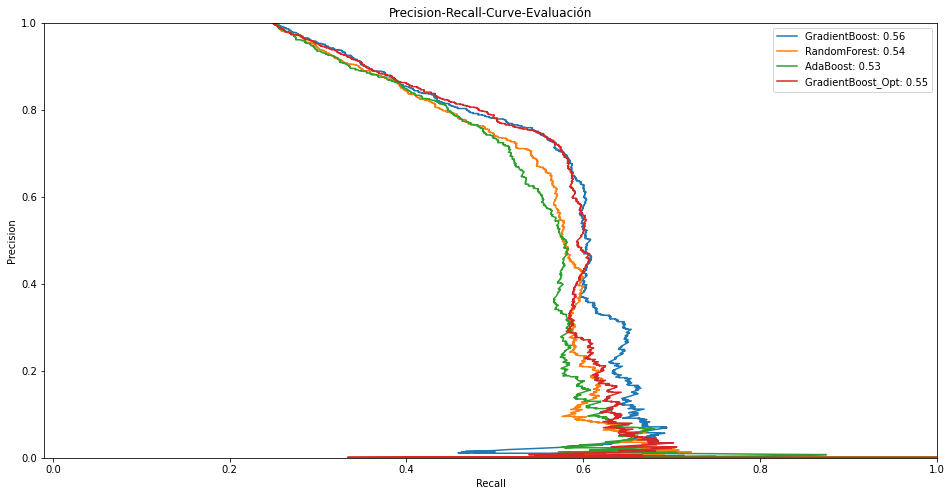

In [265]:
plt.figure(figsize=(16,8))
plt.title('Precision-Recall-Curve-Evaluación')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(prec_GBC, rec_GBC, label='GradientBoost: {a}'.format(a=round(ap_pr_GBC_GS, 2)))
plt.plot(prec_RF, rec_RF, label='RandomForest: {a}'.format(a=round(ap_pr_RF_GS, 2)))
plt.plot(prec_ABC, rec_ABC, label='AdaBoost: {a}'.format(a=round(ap_pr_ABC_GS, 2)))
plt.plot(prec_GBC_O, rec_GBC_O, label='GradientBoost_Opt: {a}'.format(a=round(ap_pr_GBC_GS2, 2)))
plt.axis([-0.01,1,0,1])
plt.legend()
plt.show()

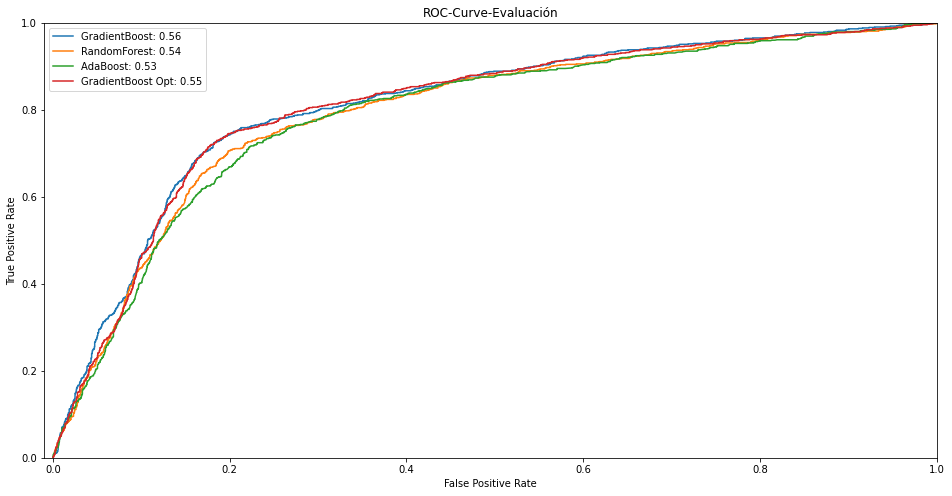

In [266]:
plt.figure(figsize=(16,8))
plt.title('ROC-Curve-Evaluación')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(roc_prec_GBC, roc_rec_GBC, label='GradientBoost: {a}'.format(a=round(ap_pr_GBC_GS, 2)))
plt.plot(roc_prec_RF, roc_rec_RF, label='RandomForest: {a}'.format(a=round(ap_pr_RF_GS, 2)))
plt.plot(roc_prec_ABC, roc_rec_ABC, label='AdaBoost: {a}'.format(a=round(ap_pr_ABC_GS, 2)))
plt.plot(roc_prec_GBC_O, roc_rec_GBC_O, label='GradientBoost Opt: {a}'.format(a=round(ap_pr_GBC_GS2, 2)))
plt.axis([-0.01,1,0,1])
plt.legend()
plt.show()